# Import Libraries

In [374]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

# Loading Data

In [375]:
df = pd.read_csv("dataset/clean_col_dataset.csv")

In [376]:
# check col names
df.columns

Index(['customerid', 'age', 'gender', 'tenure', 'usage_frequency',
       'support_calls', 'payment_delay', 'subscription_type',
       'contract_length', 'total_spend', 'last_interaction', 'churn'],
      dtype='object')

In [377]:
# check col types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customerid         440832 non-null  float64
 1   age                440832 non-null  float64
 2   gender             440832 non-null  object 
 3   tenure             440832 non-null  float64
 4   usage_frequency    440832 non-null  float64
 5   support_calls      440832 non-null  float64
 6   payment_delay      440832 non-null  float64
 7   subscription_type  440832 non-null  object 
 8   contract_length    440832 non-null  object 
 9   total_spend        440832 non-null  float64
 10  last_interaction   440832 non-null  float64
 11  churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [378]:
# check missing value
df.isnull().sum()

customerid           1
age                  1
gender               1
tenure               1
usage_frequency      1
support_calls        1
payment_delay        1
subscription_type    1
contract_length      1
total_spend          1
last_interaction     1
churn                1
dtype: int64

In [379]:
# check data row missing value
df[df.isnull().any(axis=1)]

,customerid,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [380]:
# drop missing value
df = df.dropna()

In [381]:
# check missing value
df.isnull().sum()

customerid           0
age                  0
gender               0
tenure               0
usage_frequency      0
support_calls        0
payment_delay        0
subscription_type    0
contract_length      0
total_spend          0
last_interaction     0
churn                0
dtype: int64

# Feature

## Feature Selection

In [382]:
# copy df to dataframe named df_model
df_model = df.copy()

In [383]:
df.columns

Index(['customerid', 'age', 'gender', 'tenure', 'usage_frequency',
       'support_calls', 'payment_delay', 'subscription_type',
       'contract_length', 'total_spend', 'last_interaction', 'churn'],
      dtype='object')

In [384]:
df["contract_length"].value_counts()

contract_length
Annual       177198
Quarterly    176530
Monthly       87104
Name: count, dtype: int64

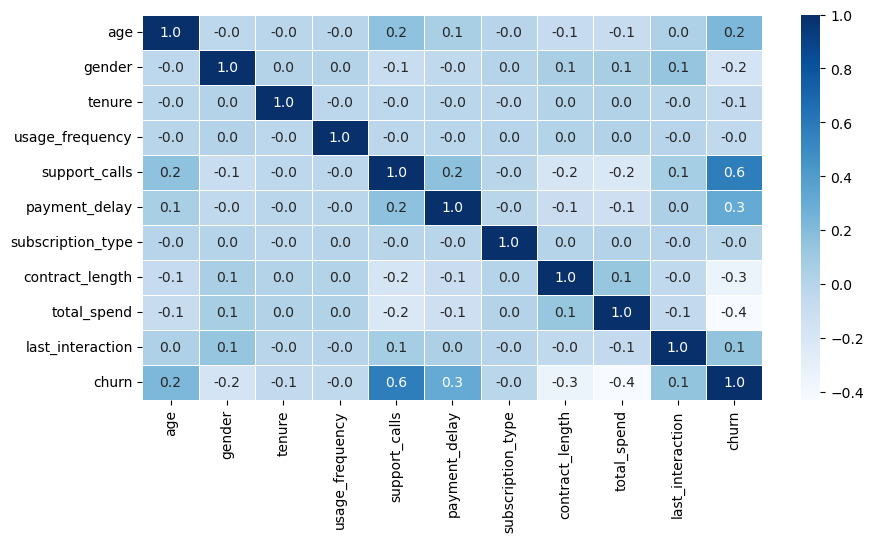

In [385]:
df["gender"] = df["gender"].map({"Female": 0, "Male": 1})
df["subscription_type"] = df["subscription_type"].map({"Basic": 1, "Standard": 2, "Premium": 3})
df["contract_length"] = df["contract_length"].map({"Monthly": 1, "Quarterly": 2, "Annual": 3})

matrix = df[['age', 'gender', 'tenure', 'usage_frequency',
       'support_calls', 'payment_delay', 'subscription_type',
       'contract_length', 'total_spend', 'last_interaction', 'churn']]

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(matrix.corr(), annot=True, linewidths=0.5, fmt=".1f", ax=ax, cmap="Blues")
plt.show()

In [386]:
for col in df_model.columns:
    contingency_table = pd.crosstab(df_model[col],df_model["churn"])
    print(f"column {col} {stats.chi2_contingency(contingency_table).pvalue}")

column customerid 0.49929187925902047
column age 0.0
column gender 0.0
column tenure 0.0
column usage_frequency 1.2275501348595206e-308
column support_calls 0.0
column payment_delay 0.0
column subscription_type 3.6452152042998097e-41
column contract_length 0.0
column total_spend 0.0
column last_interaction 0.0
column churn 0.0


In [387]:
# drop customerid, last_interaction
df_model = df_model.drop(columns=["customerid"])

In [388]:
df_model.columns

Index(['age', 'gender', 'tenure', 'usage_frequency', 'support_calls',
       'payment_delay', 'subscription_type', 'contract_length', 'total_spend',
       'last_interaction', 'churn'],
      dtype='object')

## Handling Missing Value

In [389]:
# check missing value
df_model.isnull().sum()

age                  0
gender               0
tenure               0
usage_frequency      0
support_calls        0
payment_delay        0
subscription_type    0
contract_length      0
total_spend          0
last_interaction     0
churn                0
dtype: int64

In [390]:
# check data row missing value
df_model[df_model.isnull().any(axis=1)]

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn


In [391]:
# drop missing value
df_model = df_model.dropna()

In [392]:
# check missing value
df_model.isnull().sum()

age                  0
gender               0
tenure               0
usage_frequency      0
support_calls        0
payment_delay        0
subscription_type    0
contract_length      0
total_spend          0
last_interaction     0
churn                0
dtype: int64

## Handling Outliers

In [393]:
# check col names
df_model.columns

Index(['age', 'gender', 'tenure', 'usage_frequency', 'support_calls',
       'payment_delay', 'subscription_type', 'contract_length', 'total_spend',
       'last_interaction', 'churn'],
      dtype='object')

In [394]:
# init col to check
num_col = ['age', 'tenure', 'usage_frequency', 'support_calls',
           'payment_delay', 'total_spend', 'last_interaction']

# init col_outliers
col_outliers = []

# init df_outliers
df_outliers = pd.DataFrame()

print("Outliers Overview:")
print("")

for col in num_col:
    print(col)

    # skewness
    skew_col = df_model[col].skew()
    print(f"skewness {col}       = {skew_col}")
    if skew_col > 0.5 or skew_col < -0.5:
        print("skewed")
    else:
        print("normal")

    # q1 q3 iqr
    q1_col = df_model[col].quantile(0.25)
    q3_col = df_model[col].quantile(0.75)
    iqr_col = q3_col - q1_col

    # lower upper boundary
    ub_col = q3_col + 1.5 * iqr_col
    lb_col = q1_col - 1.5 * iqr_col

    print(f"upper boundary {col} = {ub_col}")
    print(f"lower boundary {col} = {lb_col}")

    # outliers
    outlier_col = df_model[col][(df_model[col] < lb_col) | (df_model[col] > ub_col)]

    if len(outlier_col) > 0:
        # count and percentage of outliers
        persentase_outliers = len(outlier_col) / len(df_model[col]) * 100
        print(f"terdapat outliers sebanyak {len(outlier_col)} row")
        print(f"dengan persentase {(persentase_outliers):.2f}%")

        # min max outliers
        min_outlier_col = outlier_col.min()
        max_outlier_col = outlier_col.max()
        print(f"min outlier_{col} = {min_outlier_col}")
        print(f"max outlier_{col} = {max_outlier_col}")

        col_outliers.append({"column": col, "outliers": len(outlier_col), "%": f"{persentase_outliers:.2f}"})
        df_outliers = pd.concat([df_outliers, outlier_col], axis=1)
    else:
        print(f"tidak ada outliers untuk kolom {col}")

    print("")

# col_outliers to dataframe
col_outliers = pd.DataFrame(col_outliers)


Outliers Overview:

age
skewness age       = 0.16201568056624352
normal
upper boundary age = 76.5
lower boundary age = 0.5
tidak ada outliers untuk kolom age

tenure
skewness tenure       = -0.061401610125141226
normal
upper boundary tenure = 91.0
lower boundary tenure = -29.0
tidak ada outliers untuk kolom tenure

usage_frequency
skewness usage_frequency       = -0.04347347834004234
normal
upper boundary usage_frequency = 44.0
lower boundary usage_frequency = -12.0
tidak ada outliers untuk kolom usage_frequency

support_calls
skewness support_calls       = 0.6668085055364663
skewed
upper boundary support_calls = 13.5
lower boundary support_calls = -6.5
tidak ada outliers untuk kolom support_calls

payment_delay
skewness payment_delay       = 0.2674071254645739
normal
upper boundary payment_delay = 38.5
lower boundary payment_delay = -13.5
tidak ada outliers untuk kolom payment_delay

total_spend
skewness total_spend       = -0.4571740758349857
normal
upper boundary total_spend = 1355.

In [395]:
# show column has an outliers
col_outliers

""


insight:
- tidak ada outliers pada kolom numerik

## Scaling

In [396]:
df_model_num = df_model[num_col]
df_model_num

,age,tenure,usage_frequency,support_calls,payment_delay,total_spend,last_interaction
0,30.0,39.0,14.0,5.0,18.0,932.00,17.0
1,65.0,49.0,1.0,10.0,8.0,557.00,6.0
2,55.0,14.0,4.0,6.0,18.0,185.00,3.0
3,58.0,38.0,21.0,7.0,7.0,396.00,29.0
4,23.0,32.0,20.0,5.0,8.0,617.00,20.0
...,...,...,...,...,...,...,...
440828,42.0,54.0,15.0,1.0,3.0,716.38,8.0
440829,25.0,8.0,13.0,1.0,20.0,745.38,2.0
440830,26.0,35.0,27.0,1.0,5.0,977.31,9.0
440831,28.0,55.0,14.0,2.0,0.0,602.55,2.0


In [397]:
# scaling df_model[num_col]
# scaler = MinMaxScaler()
scaler = StandardScaler()
df_model_num_scaled = scaler.fit_transform(df_model_num)

In [398]:
df_model_num_scaled

array([[-0.7533263 ,  0.44875958, -0.21051068, ...,  0.60962048,
         1.2474268 ,  0.29305188],
       [ 2.05964592,  1.02827797, -1.7245625 , ..., -0.60131868,
        -0.30986452, -0.98658361],
       [ 1.25593957, -1.00003639, -1.37516593, ...,  0.60962048,
        -1.85469752, -1.33557511],
       ...,
       [-1.07480884,  0.21695223,  1.30354113, ..., -0.96460043,
         1.43558912, -0.63759211],
       [-0.91406757,  1.37598901, -0.21051068, ..., -1.57007002,
        -0.12070554, -1.45190561],
       [-0.67295566,  0.97032613,  0.48828246, ...,  0.12524482,
        -0.26513912,  0.75837388]])

## Encoding

### Nominal

In [399]:
# nominal categoric cols
cat_col_n = ["gender", "churn"]
df_model_cat_n = df_model[cat_col_n]
df_model_cat_n

,gender,churn
0,Female,1.0
1,Female,1.0
2,Female,1.0
3,Male,1.0
4,Male,1.0
...,...,...
440828,Male,0.0
440829,Female,0.0
440830,Male,0.0
440831,Male,0.0


In [400]:
# init OneHotEncoder
encoder_cat_n = OneHotEncoder()

# fit transform df_model_cat_n
df_model_cat_n_encoded = encoder_cat_n.fit_transform(df_model_cat_n).toarray()

In [401]:
df_model_cat_n_encoded

array([[1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       ...,
       [0., 1., 1., 0.],
       [0., 1., 1., 0.],
       [0., 1., 1., 0.]])

### Ordinal

In [402]:
# nominal categoric cols
cat_col_o = ["subscription_type", "contract_length"]
df_model_cat_o = df_model[cat_col_o]
df_model_cat_o

,subscription_type,contract_length
0,Standard,Annual
1,Basic,Monthly
2,Basic,Quarterly
3,Standard,Monthly
4,Basic,Monthly
...,...,...
440828,Premium,Annual
440829,Premium,Annual
440830,Standard,Quarterly
440831,Standard,Quarterly


In [403]:
df_model_cat_o

,subscription_type,contract_length
0,Standard,Annual
1,Basic,Monthly
2,Basic,Quarterly
3,Standard,Monthly
4,Basic,Monthly
...,...,...
440828,Premium,Annual
440829,Premium,Annual
440830,Standard,Quarterly
440831,Standard,Quarterly


In [404]:
# check subscription_type values
df_model["subscription_type"].value_counts()

subscription_type
Standard    149128
Premium     148678
Basic       143026
Name: count, dtype: int64

In [405]:
# check contract_length values
df_model["contract_length"].value_counts()

contract_length
Annual       177198
Quarterly    176530
Monthly       87104
Name: count, dtype: int64

In [406]:
# init value order
subscription_type_order = ["Basic", "Standard", "Premium"]
contract_length_order = ["Monthly", "Quarterly", "Annual"]

In [407]:
# init OrdinalEncoder
encoder_cat_o = OrdinalEncoder(categories=[subscription_type_order, contract_length_order])

# fit transform encoder_cat_o
df_model_cat_o = encoder_cat_o.fit_transform(df_model_cat_o)

## Concat

In [408]:
# merging
df_model_final = np.concatenate(
    [df_model_num_scaled, df_model_cat_n_encoded, df_model_cat_o], axis=1
)

In [409]:
# check df_model_final
pd.DataFrame(df_model_final)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.753326,0.448760,-0.210511,0.454549,0.609620,1.247427,0.293052,1.0,0.0,0.0,1.0,1.0,2.0
1,2.059646,1.028278,-1.724562,2.083100,-0.601319,-0.309865,-0.986584,1.0,0.0,0.0,1.0,0.0,0.0
2,1.255940,-1.000036,-1.375166,0.780259,0.609620,-1.854698,-1.335575,1.0,0.0,0.0,1.0,0.0,1.0
3,1.497051,0.390808,0.604748,1.105969,-0.722413,-0.978462,1.689018,0.0,1.0,0.0,1.0,1.0,0.0
4,-1.315921,0.043097,0.488282,0.454549,-0.601319,-0.060698,0.642043,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
440827,0.211121,1.318037,-0.094045,-0.848291,-1.206788,0.352005,-0.753923,0.0,1.0,1.0,0.0,2.0,2.0
440828,-1.155179,-1.347747,-0.326976,-0.848291,0.851808,0.472436,-1.451906,1.0,0.0,1.0,0.0,2.0,2.0
440829,-1.074809,0.216952,1.303541,-0.848291,-0.964600,1.435589,-0.637592,0.0,1.0,1.0,0.0,1.0,1.0
440830,-0.914068,1.375989,-0.210511,-0.522581,-1.570070,-0.120706,-1.451906,0.0,1.0,1.0,0.0,1.0,1.0


## Dimensionality Reduction

In [410]:
# pca fit
pca = PCA()
pca.fit(df_model_final)

PCA()

In [411]:
# components length
len_components = len(pca.explained_variance_ratio_)
len_components

13

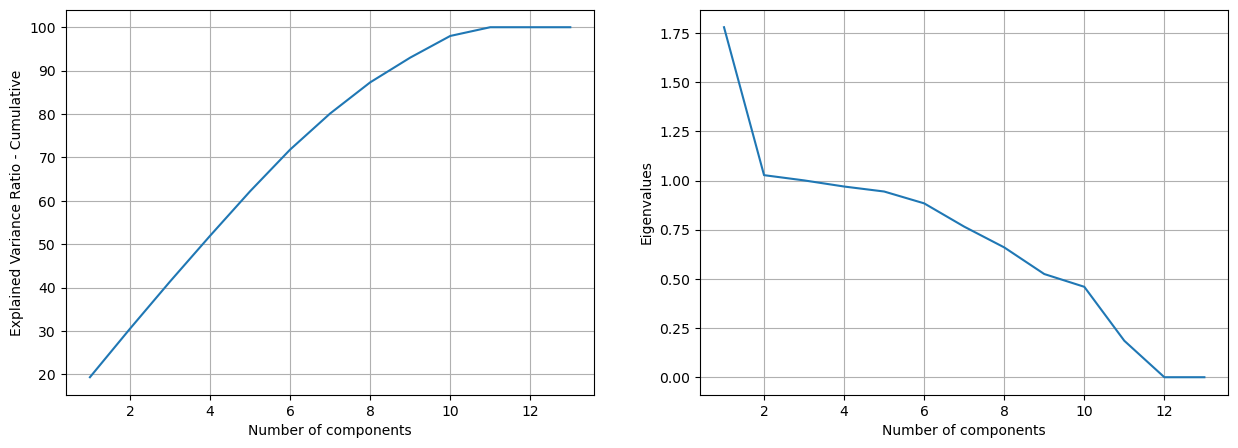

In [412]:
# Plot the Cummulative of Explained Variance Ratio
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.plot(range(1, len_components + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained Variance Ratio - Cumulative")

# Plot the Eigenvalues
plt.subplot(1, 2, 2)
plt.grid(True)
plt.plot(range(1, len_components + 1), pca.explained_variance_)
plt.xlabel("Number of components")
plt.ylabel("Eigenvalues")

plt.show()

In [413]:
# Check n_features to keep 90% information
cumsum = np.cumsum(pca.explained_variance_ratio_)
n_features = np.argmax(cumsum >= 0.90) + 1
n_features

9

In [414]:
# train model
pca = PCA(n_components=n_features)
pca.fit(df_model_final)

df_model_final_pca = pca.transform(df_model_final)

# Model Definition

## Elbow Plot

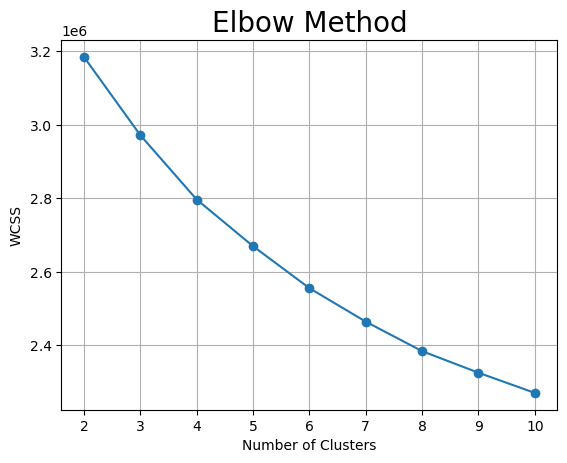

In [415]:
# Find the optimal number of clusters using Elbow Method
wcss = []
random_state = 13
max_cluster = 10
max_iter = 100
n_init = 10

for i in range(2, max_cluster+1):
    km = KMeans(n_clusters = i,
                init = "k-means++",
                max_iter = max_iter,
                n_init = n_init,
                random_state = random_state)
    km.fit(df_model_final_pca)
    wcss.append(km.inertia_)

plt.plot(range(2, max_cluster+1), wcss, marker ="o")
plt.grid(True)
plt.title("Elbow Method", fontsize = 20)
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

## Silhouette Plot

In [416]:
# Function to create Silhouette Plot
def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = max_iter, n_init = n_init, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

In [417]:
# # call plot_silhouette func
# plot_silhouette(range(2, max_cluster), df_model_final_pca, random_state)

## Init K-means with Optimal Cluster

In [418]:
# init model kmeans
km = KMeans(n_clusters = 4, init = "k-means++", max_iter = max_iter, n_init = 10, random_state = random_state)

# Model Clustering

In [419]:
# fit optimal number of clusters (3)
km = km.fit(df_model_final_pca)

# predict cluster
pred = km.predict(df_model_final_pca)
pred

array([2, 3, 3, ..., 1, 1, 0], dtype=int32)

In [420]:
# insert clustering result into original dataset
df_clustered = df.copy()
df_clustered["cluster"] = pred
df_clustered

,customerid,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn,cluster
0,2.0,30.0,0,39.0,14.0,5.0,18.0,2,3,932.00,17.0,1.0,2
1,3.0,65.0,0,49.0,1.0,10.0,8.0,1,1,557.00,6.0,1.0,3
2,4.0,55.0,0,14.0,4.0,6.0,18.0,1,2,185.00,3.0,1.0,3
3,5.0,58.0,1,38.0,21.0,7.0,7.0,2,1,396.00,29.0,1.0,3
4,6.0,23.0,1,32.0,20.0,5.0,8.0,1,1,617.00,20.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
440828,449995.0,42.0,1,54.0,15.0,1.0,3.0,3,3,716.38,8.0,0.0,1
440829,449996.0,25.0,0,8.0,13.0,1.0,20.0,3,3,745.38,2.0,0.0,1
440830,449997.0,26.0,1,35.0,27.0,1.0,5.0,2,2,977.31,9.0,0.0,1
440831,449998.0,28.0,1,55.0,14.0,2.0,0.0,2,2,602.55,2.0,0.0,1


In [421]:
# save to csv
df_clustered.to_csv("dataset/df_clustered.csv", index=False)

# EDA Cluster

## Cluster 0

In [422]:
# describe cluster 0
cluster_0 = df_clustered[df_clustered["cluster"] == 0]
cluster_0.describe().T

,count,mean,std,min,25%,50%,75%,max
customerid,91218.0,293278.119604,116862.125876,13.0,238557.5000,319111.50,383708.2500,449999.0
age,91218.0,36.426878,9.741690,18.0,29.0000,37.00,44.0000,65.0
gender,91218.0,0.886568,0.317121,0.0,1.0000,1.00,1.0000,1.0
tenure,91218.0,32.214092,17.134211,1.0,18.0000,33.00,47.0000,60.0
usage_frequency,91218.0,16.234811,8.497525,1.0,9.0000,17.00,24.0000,30.0
support_calls,91218.0,1.778969,1.609816,0.0,0.0000,2.00,3.0000,10.0
payment_delay,91218.0,10.211197,6.729984,0.0,4.0000,10.00,15.0000,30.0
subscription_type,91218.0,2.028361,0.812110,1.0,1.0000,2.00,3.0000,3.0
contract_length,91218.0,2.416727,0.614370,1.0,2.0000,2.00,3.0000,3.0
total_spend,91218.0,744.630973,164.740635,101.0,620.4925,757.14,883.3775,1000.0


## Cluster 1

In [423]:
# describe cluster 1
cluster_1 = df_clustered[df_clustered["cluster"] == 1]
cluster_1.describe().T

,count,mean,std,min,25%,50%,75%,max
customerid,141125.0,320578.855589,99207.586758,11.0,283051.00,338013.00,393017.00,449998.0
age,141125.0,36.296177,9.511573,18.0,29.00,37.00,44.00,65.0
gender,141125.0,0.486314,0.499814,0.0,0.00,0.00,1.00,1.0
tenure,141125.0,32.150838,17.124326,1.0,17.00,33.00,47.00,60.0
usage_frequency,141125.0,16.175901,8.493424,1.0,9.00,16.00,23.00,30.0
support_calls,141125.0,1.685973,1.471391,0.0,0.00,1.00,3.00,10.0
payment_delay,141125.0,10.061236,6.431374,0.0,5.00,10.00,15.00,30.0
subscription_type,141125.0,2.025105,0.810204,1.0,1.00,2.00,3.00,3.0
contract_length,141125.0,2.452011,0.573353,1.0,2.00,2.00,3.00,3.0
total_spend,141125.0,747.673385,156.117110,100.0,624.43,755.09,879.81,1000.0


## Cluster 2

In [424]:
# describe cluster 2
cluster_2 = df_clustered[df_clustered["cluster"] == 2]
cluster_2.describe().T

,count,mean,std,min,25%,50%,75%,max
customerid,99167.0,130597.317888,75419.131366,2.0,65349.5,130380.0,195911.500,447130.0
age,99167.0,29.685712,7.301661,18.0,23.0,29.0,36.000,47.0
gender,99167.0,0.475682,0.499411,0.0,0.0,0.0,1.000,1.0
tenure,99167.0,30.182934,17.369951,1.0,15.0,30.0,45.000,60.0
usage_frequency,99167.0,15.305223,8.664533,1.0,8.0,15.0,23.000,30.0
support_calls,99167.0,6.087186,2.888687,0.0,4.0,6.0,9.000,10.0
payment_delay,99167.0,16.669406,8.733954,0.0,10.0,17.0,24.000,30.0
subscription_type,99167.0,2.001634,0.816441,1.0,1.0,2.0,3.000,3.0
contract_length,99167.0,1.929543,0.814122,1.0,1.0,2.0,3.000,3.0
total_spend,99167.0,480.928776,247.132348,100.0,268.0,453.0,675.355,1000.0


## Cluster 3

In [425]:
# describe cluster 3
cluster_3 = df_clustered[df_clustered["cluster"] == 3]
cluster_3.describe().T

,count,mean,std,min,25%,50%,75%,max
customerid,109322.0,131886.233878,77211.756827,3.0,65724.5000,131579.5,196833.500,449213.0
age,109322.0,54.591189,6.614527,40.0,49.0000,55.0,60.000,65.0
gender,109322.0,0.490093,0.499904,0.0,0.0000,0.0,1.000,1.0
tenure,109322.0,30.276157,17.311704,1.0,15.0000,30.0,45.000,60.0
usage_frequency,109322.0,15.430975,8.666795,1.0,8.0000,15.0,23.000,30.0
support_calls,109322.0,5.352043,3.050709,0.0,3.0000,5.0,8.000,10.0
payment_delay,109322.0,15.653876,8.815942,0.0,8.0000,16.0,23.000,30.0
subscription_type,109322.0,1.994146,0.815138,1.0,1.0000,2.0,3.000,3.0
contract_length,109322.0,1.956806,0.813699,1.0,1.0000,2.0,3.000,3.0
total_spend,109322.0,524.187485,253.244800,100.0,306.5025,513.0,735.945,1000.0
